In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot, get_max_H_dist, plot_opt, get_conditional_mode
import tensorflow as tf
from neural_circuits.SC_Circuit_4 import SC_acc, SC_acc_diff, SC_acc_opto, \
                             SC_acc_var, SC_sim, \
                             SC_sim_opto, unwrap, \
                             get_schur_eigs, z_to_W, \
                            z_from_eigs, z_from_eig_perturb, \
                            z_from_eigs_analytic, eigs_from_z_analytic, \
                            get_SC_z_mode_path, get_SC_sens_vs, \
                            perturbed_acc, perturbed_acc_plots, \
                            plot_SC_responses
from scipy.special import expit
from sklearn.linear_model import LinearRegression
import scipy.stats
import os

basedir  = "figures"
figdir = os.path.join(basedir, "fig3")
fig5dir = os.path.join(basedir, "fig5")
figdir1 = os.path.join(basedir, "figSC1")
figdir2 = os.path.join(basedir, "figSC2")
figdir3 = os.path.join(basedir, "figSC3")
figdir4 = os.path.join(basedir, "figSC4")
figdir5 = os.path.join(basedir, "figSC5")
figdir6 = os.path.join(basedir, "figSC6")

red = '#c21f2d'
purple = '#731fc2'

c_LP = '#3B8023'
c_LA = '#EA8E4C'
c_RA = '#F4C673'
c_RP = '#81C176'

cmap_g = plt.get_cmap('Greens')
cmap_o = plt.get_cmap('Oranges')

num_plot = 500

### Define the SC Circuit model

In [2]:
lb = -5.
ub = 5.

sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit_var", parameters)

z_labels = [p.name for p in model.parameters]
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])

p = 0.75
mu_std = 0.075
model.set_eps(SC_acc_var(p))

### Load the EPI distribution

In [3]:
epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['elemwise_fn'] = ['affine' if 'affine' in path else 'spline' for path in epi_df['path']]
epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
epi_df['bnmom'] = [al_hps['bn_momentum'] for al_hps in epi_df['arch']]
epi_df['p'] = [ep['mu'][0] for ep in epi_df['EP']]
epi_df['mu_std'] = [np.sqrt(ep['mu'][2]) for ep in epi_df['EP']]
epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

mu =  np.array([p, 1-p, mu_std**2, mu_std**2])
epi_df = epi_df[(epi_df['p']==p)
              & (epi_df['elemwise_fn']=="affine")
              & (epi_df['mu_std']==mu_std)
              & (epi_df['beta']==2.)
              & (epi_df['random_seed']==3)]

paths = sorted(epi_df['path'].unique())

"""alpha, nu = 0.05, 0.25
dist, path, best_k = get_max_H_dist(model, epi_df, mu, alpha, nu, check_last_k=None)"""

path = paths[0]
best_k = 10

_epi_df = epi_df[epi_df['path'] == path]
df_row = _epi_df.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

### Figure SC6 (EPI optimization)

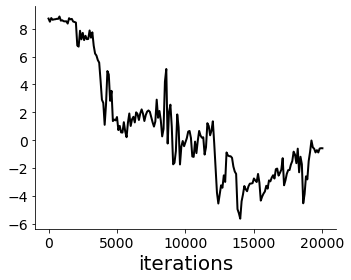

0 -
1 -
2 --
3 --


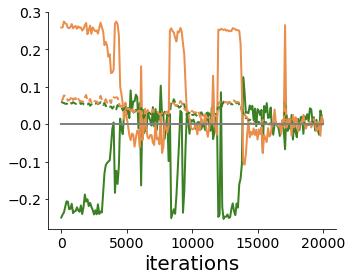

In [4]:
cs = [c_LP, c_LA]
_epi_df = epi_df[epi_df['path'] == path]
plot_opt(_epi_df, max_k=best_k, cs=cs, fontsize=20, figdir=figdir6, save=True)

### EPI samples and simulations

In [5]:
np.random.seed(0)
tf.random.set_seed(0)
z, log_q_z = dist.nf(500)
z = z.numpy()
log_q_z = log_q_z.numpy()
u_t, v_t = SC_sim(*unwrap(z))
u_t, v_t = u_t.numpy(), v_t.numpy()
T_x = np.mean(expit(100.*(v_t[-1,:,:,0,:] - v_t[-1,:,:,3,:])), axis=2)
pP = T_x[:,0]
pA = 1. - T_x[:,1]
#m, b, r, pval, _ = scipy.stats.linregress(T_x[:,0], 1.-T_x[:,1])
#print('pP to pA correlation', r, 'p value', pval)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


### Collect the modes along the ridge

In [6]:
z_modes_file = "SC_z_modes.npz"
if os.path.exists(z_modes_file):
    npzfile = np.load(z_modes_file)
    vals, z_stars_top, z_stars_bot = npzfile['vals'], npzfile['z_stars_top'], npzfile['z_stars_bot']
else:
    vals = np.array([-1.5, -1.4, -1.3, -1.2, -1.1, -1.05])
    num_zs = vals.shape[0]
    num_steps = num_zs*[200]
    lr = 2.5e-4
    z_init_top = np.array([0.5986245, -3.3982022, -1.1453137, -1.5])
    #z_init_top = np.array([-0.02196542, -3.3898032, -1.0818561, -1.1])
    z_stars_top = get_SC_z_mode_path(dist, z_init_top, 3, vals, lr, num_steps, do_plot=True)
    lr = 5e-4
    z_init_bot = np.array([-1.087918 , -4.225775 , -2.4361994, -1.5])
    z_stars_bot = get_SC_z_mode_path(dist, z_init_bot, 3, vals, lr, num_steps, do_plot=True, labels=z_labels)
    np.savez(z_modes_file, vals=vals, z_stars_top=z_stars_top, z_stars_bot=z_stars_bot)

### Calculate the sensitivity dimension at each mode

In [7]:
z_stars = np.concatenate((z_stars_top, np.flip(z_stars_bot, axis=0)), axis=0)
num_zs = z_stars.shape[0]

vs = get_SC_sens_vs(z_stars, dist)
vs_lambda = np.array([eigs_from_z_analytic(vs[i]) for i in range(vs.shape[0])]) / 2.

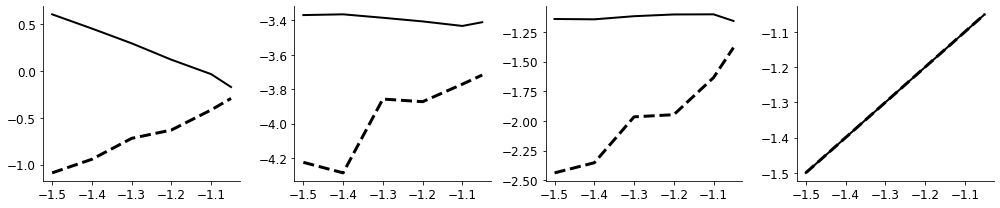

In [37]:
fig, axs = plt.subplots(1, 4, figsize=(14,3))
for i, label in enumerate(z_labels):
    ax = axs[i]
    ax.plot(vals, z_stars_top[:,i], 'k')
    ax.plot(vals, z_stars_bot[:,i], 'k--', lw=3.)
plt.tight_layout()
plt.savefig(os.path.join(figdir4, "z_trends.png"))
plt.show()

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


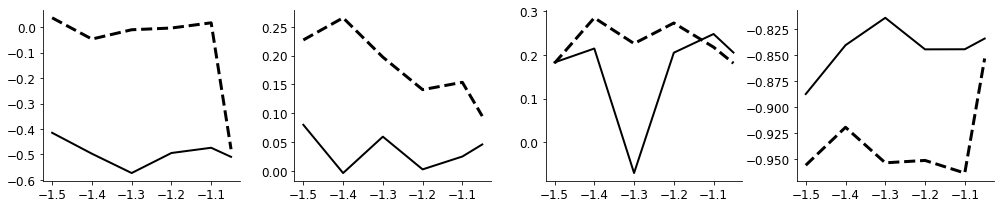

In [38]:
vs_top = get_SC_sens_vs(z_stars_top, dist)
vs_bot = get_SC_sens_vs(z_stars_bot, dist)
fig, axs = plt.subplots(1, 4, figsize=(14,3))
for i, label in enumerate(z_labels):
    ax = axs[i]
    ax.plot(vals, vs_top[:,i], 'k')
    ax.plot(vals, vs_bot[:,i], 'k--', lw=3.)
plt.tight_layout()
plt.savefig(os.path.join(figdir4, "v_trends.png"))
plt.show()

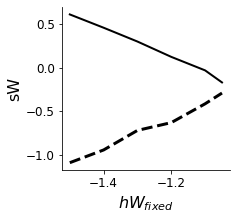

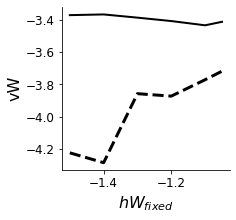

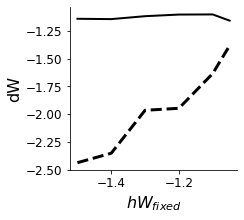

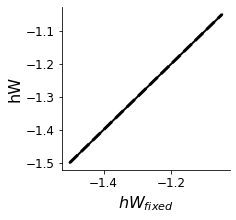

In [39]:
for i, label in enumerate(z_labels):
    plt.figure(figsize=(3,3))
    plt.plot(vals, z_stars_top[:,i], 'k')
    plt.plot(vals, z_stars_bot[:,i], 'k--', lw=3.)
    plt.xlabel(r'$hW_{fixed}$')
    plt.ylabel(label)
    plt.show()

### Define colors for different regimes

In [46]:
red = np.array([216, 0, 0, 256]) / 256.
purple = np.array([102, 0, 204, 256]) / 256.
half = (red + purple) / 2.
cmap_top = matplotlib.colors.LinearSegmentedColormap.from_list("top", [red, half])
cmap_bot = matplotlib.colors.LinearSegmentedColormap.from_list("bot", [purple, half])

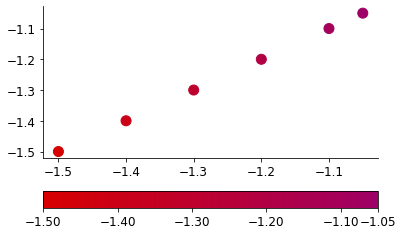

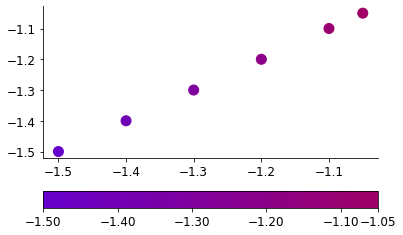

In [47]:
# make colorbars for plots
plt.figure()
plt.scatter(vals, vals, c=vals, cmap=cmap_top)
plt.colorbar(orientation='horizontal', ticks=vals)
plt.show()

plt.figure()
plt.scatter(vals, vals, c=vals, cmap=cmap_bot)
plt.colorbar(orientation='horizontal', ticks=vals)
plt.show()

## Figure 4C

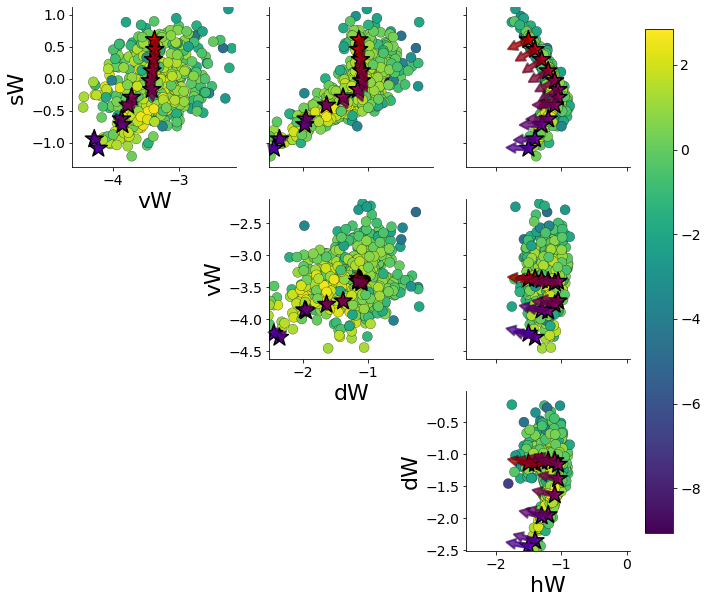

In [48]:
# colors for z_stars
vals_for_cmap = vals - np.min(vals)
vals_for_cmap = vals_for_cmap / np.max(vals_for_cmap)
c_stars = np.concatenate((cmap_top(vals_for_cmap),
                          np.flip(cmap_bot(vals_for_cmap), axis=0)),
                         axis=0)

# bounds for figure, preserve aspect
mean_z = np.mean(z, axis=0)
lim = 1.25
_lb = mean_z - lim
_ub = mean_z + lim
   
alpha = 0.5
v_len = 0.35
c_stars_clear = c_stars.copy()
c_stars_clear[:,3] = alpha
fig, axs = plt.subplots(3,3, figsize=(10,10))
for k, z_star in enumerate(z_stars):
    v = vs[k]
    z1 = z_star
    z2 = z_star + v_len*v
    for i in range(3):
        for j in range(i+1, 4):
            axs[i][j-1].annotate("", xy=[z2[j], z2[i]], xytext=[z1[j], z1[i]], 
            arrowprops=dict(headwidth=10, headlength=9, lw=2., color=np.array([0., 0., 0., alpha])))
            axs[i][j-1].annotate("", xy=[z2[j], z2[i]], xytext=[z1[j], z1[i]], 
             arrowprops=dict(headwidth=8, headlength=8, lw=1.5, color=c_stars_clear[k]))
fig, axs = pairplot(z, np.arange(4), z_labels, subplots=(fig, axs), 
                    starred=z_stars, c_starred=c_stars,
                    fontsize=22, ticksize=14, s=100, s_star=350,
                    lb=_lb, ub=_ub,
                    c=log_q_z)


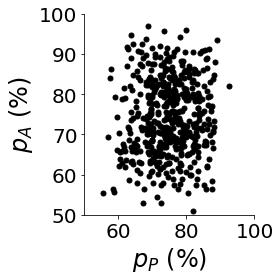

In [49]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.scatter(100*(T_x[:num_plot,0]), 100.*(1-T_x[:num_plot,1]), s=25, c='k')
ax.plot([0,1], [0,1], 'k-')
plt.xlabel(r'$p_P$ (%)', fontsize=24)
plt.ylabel(r'$p_A$ (%)', fontsize=24)
plt.xlim([50, 100])
plt.ylim([50, 100])
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "SC_T_x.pdf"))

## Figure 4D

In [44]:
fac_lim = 0.4
N_fac = 21
facs = np.linspace(-fac_lim, fac_lim, N_fac)

N_sim = 25
pPs, pAs = [], []
for k in range(num_zs):
    print('z_star %d/%d\r' % (k+1, num_zs), end="")
    z_perturb = z_stars[k][None,:] + facs[:,None]*vs[k][None,:]

    _pPs, _pAs = perturbed_acc(z_perturb, SC_sim, N_sim)
    pPs.append(_pPs)
    pAs.append(_pAs)



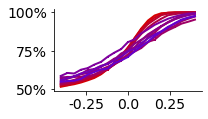

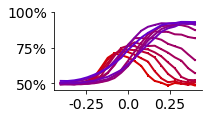

In [50]:
perturbed_acc_plots(facs, pPs, pAs, c_stars, 
                    fontsize=14, label="v1", figdir=figdir)

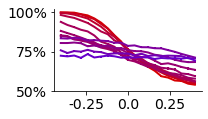

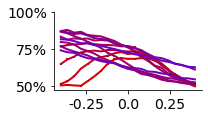

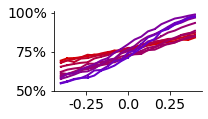

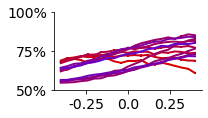

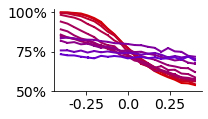

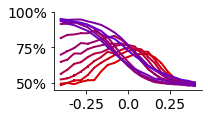

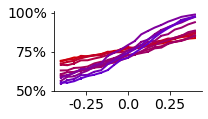

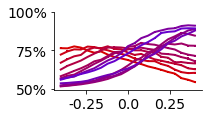

In [51]:
eig_names = ['all', 'side', 'task', 'diag']
for i, eig_name in enumerate(eig_names):
    pPs, pAs = [], []
    for k in range(num_zs):
        print('z_star %d/%d\r' % (k+1, num_zs), end="")
        eigs = np.array([0., 0., 0., 0.])
        eigs[i] = 1.
        vs_eig = z_from_eigs_analytic(eigs)
        vs_eig = vs_eig / np.linalg.norm(vs_eig)
        z_perturb = z_stars[k][None,:] + facs[:,None]*vs_eig[None,:]

        _pPs, _pAs = perturbed_acc(z_perturb, SC_sim, N_sim)
        pPs.append(_pPs)
        pAs.append(_pAs)
    perturbed_acc_plots(facs, pPs, pAs, c_stars, 
                        fontsize=14, label=eig_name, figdir=figdir)
    print("")

In [52]:
z_ind = np.where(vals==-1.2)[0][0]
z_plots = np.stack((z_stars_top[z_ind], z_stars_bot[z_ind]), axis=0)
v_plots = np.stack((vs[z_ind], vs[-z_ind]), axis=0)

[-0.4  0.   0.4]
56.0, 50.0


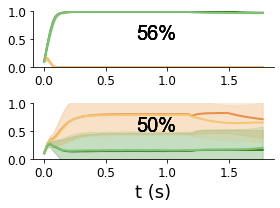

73.6, 76.1


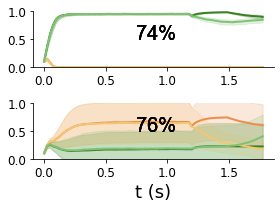

99.9, 50.0


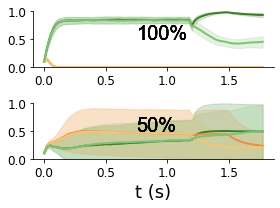

53.2, 48.4


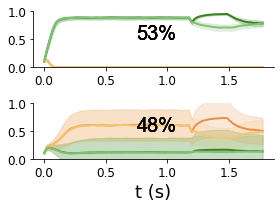

76.1, 61.2


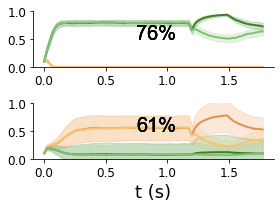

99.2, 93.5


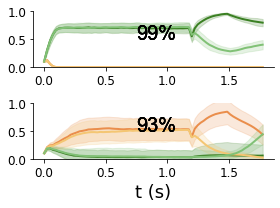

In [134]:

fac_lim = 0.4
facs = np.linspace(-fac_lim, fac_lim, 3)
for i in range(2):
    z_perturb = z_plots[i][None,:] + facs[:,None]*v_plots[i][None,:]
    _, v_t_perturb = SC_sim(*unwrap(z_perturb.astype(np.float32)))
    v_t_perturb = v_t_perturb.numpy()
    #fname = os.path.join(figdir, "z%d_" % (i+1))
    #plot_SC_responses(v_t_perturb, fname)
    fname = os.path.join(figdir2, "z%d_" % (i+1))
    plot_SC_responses(v_t_perturb, fname, figsize=(4,3))

## Fig 5 C

In [53]:
strength = 0.2
_sc_sim_opto = SC_sim_opto(strength, 'delay')
def sc_sim_opto(w,x,y,z): 
    u, v = _sc_sim_opto(w,x,y,z)
    return u[:,:,2], v[:,:,2:]
   
pPs_optos, pAs_optos = [], []
for k in range(num_zs):
    print('z_star %d/%d\r' % (k+1, num_zs), end="")
    z_perturb = z_stars[k][None,:] + facs[:,None]*vs[k][None,:]
    pPs_opto, pAs_opto = perturbed_acc(z_perturb, sc_sim_opto, N_sim)
    pPs_optos.append(pPs_opto)
    pAs_optos.append(pAs_opto)

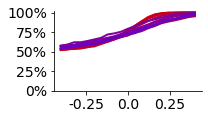

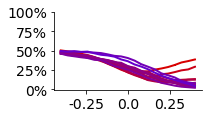

In [54]:
perturbed_acc_plots(facs, pPs_optos, pAs_optos, c_stars, 
                    fontsize=14, label="v1_opto", figdir=fig5dir)

76.8, 24.6


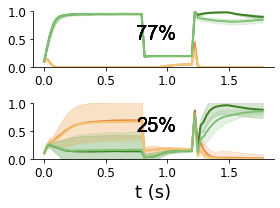

75.5, 26.5


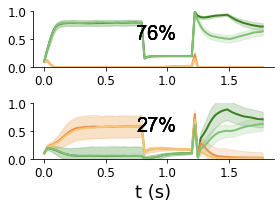

In [138]:
strength = 0.2
sc_sim_opto = SC_sim_opto(strength, 'delay')
_, v_t_stars = sc_sim_opto(*unwrap(z_plots))
v_t_stars = v_t_stars.numpy()[:,:,2:,:,:]

fname = os.path.join(figdir5, "opt_")
plot_SC_responses(v_t_stars, fname, figsize=(4,3))

In [139]:
print(vs_lambda)

[[-0.51985028  0.1847956  -0.78270785  0.28805336]
 [-0.56336122  0.06245857 -0.77433626  0.28129408]
 [-0.69947948  0.18584036 -0.6878147   0.05570257]
 [-0.56561484  0.07380762 -0.77334563  0.27671078]
 [-0.52262662  0.073757   -0.79564955  0.29725938]
 [-0.54612609  0.08251618 -0.79757074  0.24252475]
 [-0.52831084  0.14400373 -0.80444955  0.23024233]
 [-0.28753824  0.45798657 -0.65923385  0.52247563]
 [-0.27035772  0.40766144 -0.68473114  0.54024266]
 [-0.27024737  0.45723989 -0.69389813  0.48621334]
 [-0.20776936  0.42643157 -0.7588652   0.44621924]
 [-0.25549996  0.51921764 -0.66408874  0.47341199]]


In [22]:
def plot_corr(x, xlabel, y, ylabel, ylim=None, 
                 s=10, num_plot=None, c=None, fontsize=20):
    x_mean, x_std = np.mean(x) ,np.std(x)
    lin_model = scipy.stats.linregress(x, y)
    if c is None:
        c = 'k'
    xticksize = fontsize-6
    yticksize = fontsize-4
    titlesize = fontsize-4
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    x = x[:num_plot]
    y = y[:num_plot]
    
    ax.scatter(x, y, s=s, c=c)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    plt.setp(ax.get_xticklabels(), fontsize=xticksize)
    plt.setp(ax.get_yticklabels(), fontsize=yticksize)
    
    x1, x2 = x_mean-3.5*x_std, x_mean+3.5*x_std
    ax.set_xlim([x1, x2])
    m, b, r, pval, _ = lin_model
    ax.plot([x1, x2], [b + m*x1, b+m*x2], 'k--')
    if pval < 0.05:
        pval_str = ""
    else:
        pval_str = "(n.s.)"
    metric_str = (r"$\beta$=%.1E, r=%.2f," "\n" "p=%.1E %s") % (m,r,pval,pval_str)
    ax.set_title(metric_str, fontsize=titlesize)
    if ylim is not None:
        ax.set_ylim(ylim)
        
    return fig, ax

In [23]:
N_opto_test = 100
strength = 0.2
sc_acc_diff = SC_acc_diff(strength, 'delay')
diffs = sc_acc_diff(*unwrap(z[:N_opto_test,:])).numpy()
diffs[:,1] = -diffs[:,1]

0 0.6589054210404985 0.5114861379086257
1 36.992377509120814 9.060369857074151e-60
two-tailed


Ttest_relResult(statistic=-36.7726378972512, pvalue=1.5707180266575138e-59)

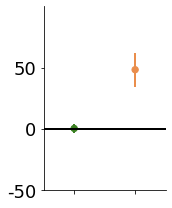

In [24]:
mean_diff = np.mean(100.*diffs, axis=0)
std_diff = np.std(100.*diffs, axis=0)
fig, ax = plt.subplots(1,1,figsize=(2.5,3))
_cs = [c_LP, c_LA]
plt.scatter([0,1], mean_diff, color=_cs, s=40)
for i in range(2):
    plt.plot([i,i], [mean_diff[i]-std_diff[i], mean_diff[i]+std_diff[i]], '-', c=_cs[i])
plt.ylim([-5, 100])
plt.xlim([-.5, 1.5])
plt.plot([-1, 2], [0, 0], 'k-')
ax.set_xticks([0,1])
ax.set_xticklabels(['', ''], fontsize=18)
ax.set_yticks([-50, 0,50])
ax.set_yticklabels([-50, 0,50], fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(figdir, "delay_error.pdf"), transparent=True)
for i in range(2):
    t, p = scipy.stats.ttest_1samp(diffs[:,i], 0.)
    print(i,t,p)
    
print('two-tailed')
scipy.stats.ttest_rel(diffs[:,0], diffs[:,1])

In [25]:
plot_corr(100.*acc_opto[:,0], r'$p_P$', 100*(1.-acc_opto[:,3]), r'$p_{A,opto}$',
                    s=5, num_plot=500, fontsize=22)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "AntiError_P.pdf"), transparent=True)

plot_corr(100.*(1.-acc_opto[:,1]), r'$p_A$', 100*(1.-acc_opto[:,3]), r'$p_{A,opto}$',
                    s=5, num_plot=500, fontsize=22)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "AntiError_A.pdf"), transparent=True)

NameError: name 'acc_opto' is not defined

In [26]:
y_labels = ['Pro error (%)', r'Anti error (%)']
tasks = ['P', 'A']
ylims = [[-7.5, 7.5], [0, 75]]
for j in range(2):
    ylim = ylims[j]
    for i, eig_name in enumerate(eig_names):
        if i==0:
            y_label = y_labels[j]
        else:
            y_label = ""
        fig, ax = plot_corr(eigs[:,i], r'$\lambda_{%s}$' % eig_name, 
                    100*diffs[:,j], y_label, ylim=ylim,
                    s=5, num_plot=500, fontsize=26)
        if j==0:
            ax.set_yticks([-5, 0, 5])
        plt.tight_layout()
        plt.savefig(os.path.join(figdir5, "lambda_opto_%s_%s.pdf" % (eig_name, tasks[j])), 
                    transparent=True)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 500 and the array at index 1 has size 100

In [27]:
ylabels = [r'$p_P-p_{P,opto}$ (%)', r'$p_A-p_{A,opto}$ (%)']
plot_2corrs(pP, r'$p_P$', 100*diffs[:,0], 100*diffs[:,1], ylabels, 
             alignment='v', s=5, num_plot=500, fontsize=22)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "pP_opto.pdf"))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 500 and the array at index 1 has size 100

In [28]:
periods = ['delay', 'choice', 'total']
strengths = np.linspace(0., 1., 21)
diffs = []
approx_num = 100

for period in periods:
    _diffs = []
    for strength in strengths:
        print(period, strength)
        sc_acc_diff = SC_acc_diff(strength, period)
        _diff = sc_acc_diff(*unwrap(z[:approx_num])).numpy()
        _diff[:,1] = -_diff[:,1]
        _diffs.append(_diff)
    diffs.append(np.array(_diffs))

delay 0.0
delay 0.05
delay 0.1
delay 0.15000000000000002
delay 0.2
delay 0.25
delay 0.30000000000000004
delay 0.35000000000000003
delay 0.4
delay 0.45
delay 0.5
delay 0.55
delay 0.6000000000000001
delay 0.65
delay 0.7000000000000001
delay 0.75
delay 0.8
delay 0.8500000000000001
delay 0.9
delay 0.9500000000000001
delay 1.0
choice 0.0
choice 0.05
choice 0.1
choice 0.15000000000000002
choice 0.2
choice 0.25
choice 0.30000000000000004
choice 0.35000000000000003
choice 0.4
choice 0.45
choice 0.5
choice 0.55
choice 0.6000000000000001
choice 0.65
choice 0.7000000000000001
choice 0.75
choice 0.8
choice 0.8500000000000001
choice 0.9
choice 0.9500000000000001
choice 1.0
total 0.0
total 0.05
total 0.1
total 0.15000000000000002
total 0.2
total 0.25
total 0.30000000000000004
total 0.35000000000000003
total 0.4
total 0.45
total 0.5
total 0.55
total 0.6000000000000001
total 0.65
total 0.7000000000000001
total 0.75
total 0.8
total 0.8500000000000001
total 0.9
total 0.9500000000000001
total 1.0


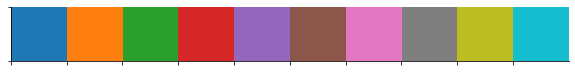

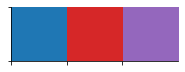

In [30]:
import seaborn as sns
pal = sns.color_palette()
sns.palplot(pal)
opto_colors = [pal[i] for i in [0, 3, 4]]
sns.palplot(opto_colors)

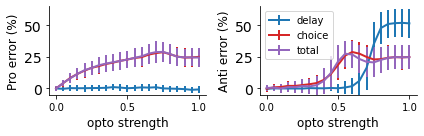

In [35]:
fig, axs = plt.subplots(1,2,figsize=(6,2))
for i, period in enumerate(periods):
    diff_mean = np.mean(100.*diffs[i], axis=1)
    diff_std = np.std(100.*diffs[i], axis=1)
    for j in range(2):
        axs[j].errorbar(1.-strengths, diff_mean[:,j], diff_std[:,j],
                        c=opto_colors[i], label=period)

ylabels = ['Pro error (%)', 'Anti error (%)']
fontsize = 12
ticksize = fontsize-2
for j in range(2):
    axs[j].set_xlabel('opto strength', fontsize=fontsize)
    axs[j].set_ylabel(ylabels[j], fontsize=fontsize)
    axs[j].set_ylim([-5, 65])
    plt.setp(axs[j].get_xticklabels(), fontsize=ticksize)
    plt.setp(axs[j].get_yticklabels(), fontsize=(ticksize+4))
axs[1].legend(fontsize=ticksize)
plt.tight_layout()
plt.savefig(os.path.join(figdir5, "strength_sweeps.pdf"))

In [ ]:
# compare sensitivity
def sensitivity(facs, d):
    #m, b, r, p, _ = scipy.stats.linregress(facs, d)
    return (d[0]+d[-1]), np.mean(d)
def rvs(D, N):
    v = np.random.normal(0., 1., (N,D))
    v = v / np.linalg.norm(v, axis=1)[:,None]
    return v

facs = np.linspace(-.3, .3, 5)
N_rand = 100
rand_vs = rvs(4,N_rand)
ms = []
m_rands = []
ind = 0
for z_i, v_i in zip(z_stars, vs):
    z_perturb = z_i + facs[:,None]*v_i
    T_x_perturb = model.eps(z_perturb.astype(np.float32)).numpy()
    print(T_x_perturb)
    d = np.linalg.norm((T_x_perturb - mu[None,:])[:,:2], axis=1)
    print(d)
    m, r = sensitivity(np.abs(facs), d)
    
    _m_rands = []
    for j in range(N_rand):
        z_perturb = z_i + facs[:,None]*rand_vs[j]
        T_x_perturb = model.eps(z_perturb.astype(np.float32)).numpy()
        d = np.linalg.norm((T_x_perturb - mu[None,:])[:,:2], axis=1)
        m, r = sensitivity(np.abs(facs), d)
        _m_rands.append(m)
    ms.append(m)
    m_rands.append(np.array(_m_rands))
    ind += 1
    if ind == 3:
        break
ms = np.array(ms)
m_rands = np.array(m_rands)

plt.figure()
for i in range(ms.shape[0]):
    x_jit = i + np.random.normal(0., 0.1, (N_rand,))
    plt.scatter(x_jit, m_rands[i], color='k')
plt.plot(np.arange(ms.shape[0]), ms, 'r-')
plt.show()

    